In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import optuna
from sklearn.model_selection import StratifiedKFold
import random
import numpy as np
from sklearn.utils import resample
import matplotlib.pyplot as plt


In [2]:
train=pd.read_csv('../balanced_cleaned_trian_dataset.csv',index_col=0)
test_set=pd.read_csv('../testset.csv',index_col=0)

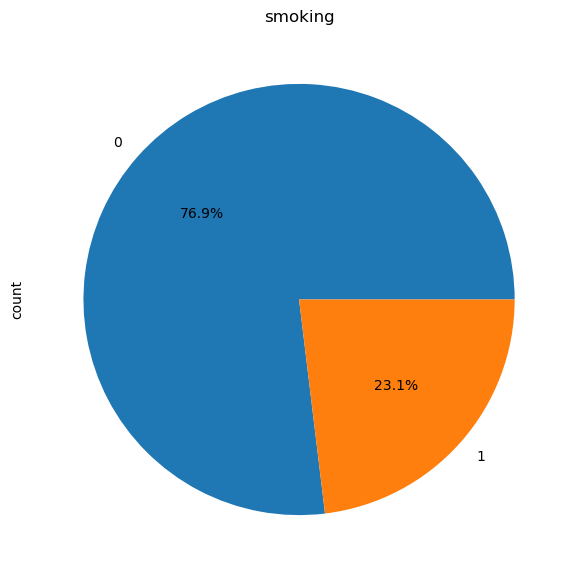

In [3]:
df_0 = train[train['smoking'] == 0]
df_1 = train[train['smoking'] == 1]
n_0 = len(df_0)
n_1 = int(n_0 *0.3)

df_1_resampled = resample(df_1, replace=False, n_samples=n_1, random_state=42)

train_resampled = pd.concat([df_1_resampled, df_0]).sample(frac=1, random_state=42).reset_index(drop=True)

fig, axes = plt.subplots(figsize=(7, 7))
train_resampled['smoking'].value_counts().plot.pie(autopct='%1.1f%%')
axes.set_title('smoking')
plt.show()


In [4]:
train_resampled['smoking'].value_counts()

smoking
0    10000
1     3000
Name: count, dtype: int64

In [5]:
train_copy=train_resampled.drop('id',axis=1)
X = train_copy.drop('smoking', axis=1)
y = train_copy['smoking']

test_set=test_set.drop('id',axis=1)
X_test_new= test_set.drop('smoking', axis=1)
y_test_new = test_set['smoking']

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    hidden1 = trial.suggest_int('hidden1', 10, 128)
    hidden2 = trial.suggest_int('hidden2', 10, 64)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    epochs = trial.suggest_int('epochs', 20, 60)

    scores = []

    for train_idx, val_idx in skf.split(X, y):
        
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_fold)
        X_val_scaled = scaler.transform(X_val_fold)

        
        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
        X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_fold.values, dtype=torch.float32).view(-1, 1)
        y_val_tensor = torch.tensor(y_val_fold.values, dtype=torch.float32).view(-1, 1)

       
        class MLP(nn.Module):
            def __init__(self, input_dim):
                super().__init__()
                self.model = nn.Sequential(
                    nn.Linear(input_dim, hidden1),
                    nn.ReLU(),
                    nn.Linear(hidden1, hidden2),
                    nn.ReLU(),
                    nn.Linear(hidden2, 1),
                    nn.Sigmoid()
                )
            def forward(self, x):
                return self.model(x)
        set_seed(42)
        model = MLP(X_train_tensor.shape[1])
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train_tensor)
            loss = criterion(outputs, y_train_tensor)
            loss.backward()
            optimizer.step()

        
        model.eval()
        with torch.no_grad():
            y_pred = model(X_val_tensor)
            y_pred_labels = (y_pred > 0.5).float()
            acc = accuracy_score(y_val_tensor, y_pred_labels)
            


            y_pred_train = model(X_train_tensor)
            y_pred_train_labels = (y_pred_train > 0.5).float()
            acc_train = accuracy_score(y_train_tensor, y_pred_train_labels)
            overfit_penalty = abs(acc_train - acc)


            score = 0.5 * acc - 5 * overfit_penalty
            scores.append(score)

            

    return np.mean(scores)


sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=20)

print("best_params:", study.best_params)


[I 2025-08-01 14:31:40,136] A new study created in memory with name: no-name-2e44c42b-0605-4dce-8185-a0f97803e15a
[I 2025-08-01 14:31:41,122] Trial 0 finished with value: 0.36242307692307685 and parameters: {'hidden1': 54, 'hidden2': 62, 'lr': 0.0029106359131330704, 'epochs': 44}. Best is trial 0 with value: 0.36242307692307685.
[I 2025-08-01 14:31:41,484] Trial 1 finished with value: 0.14853846153846156 and parameters: {'hidden1': 28, 'hidden2': 18, 'lr': 0.00013066739238053285, 'epochs': 55}. Best is trial 0 with value: 0.36242307692307685.
[I 2025-08-01 14:31:42,356] Trial 2 finished with value: 0.38461538461538464 and parameters: {'hidden1': 81, 'hidden2': 48, 'lr': 0.00010994335574766199, 'epochs': 59}. Best is trial 2 with value: 0.38461538461538464.
[I 2025-08-01 14:31:42,809] Trial 3 finished with value: 0.38461538461538464 and parameters: {'hidden1': 109, 'hidden2': 21, 'lr': 0.0002310201887845295, 'epochs': 27}. Best is trial 2 with value: 0.38461538461538464.
[I 2025-08-01 1

最佳参数: {'hidden1': 81, 'hidden2': 48, 'lr': 0.00010994335574766199, 'epochs': 59}


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_new_scaler=scaler.transform(X_test_new)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

X_test_new_scaler_tensor=torch.tensor(X_test_new_scaler, dtype=torch.float32)
y_test_new_tensor=torch.tensor(y_test_new.values, dtype=torch.float32).view(-1, 1)

class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 81),
            nn.ReLU(),
            nn.Linear(81, 48),
            nn.ReLU(),
            nn.Linear(48, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)
set_seed(42)
model = MLP(input_dim=X_tensor.shape[1])

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00010994335574766199)


epochs = 59
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

model.eval()
with torch.no_grad():

    y_pred = model(X_test_new_scaler_tensor)
    y_pred_labels = (y_pred > 0.5).float()

    y_true = y_test_new_tensor.cpu().numpy()
    y_pred_labels_np = y_pred_labels.cpu().numpy()
 
    

    y_pred_train=model(X_tensor)
    y_pred_labels_train = (y_pred_train > 0.5).float()

    y_pred_labels_train_np = y_pred_labels_train.cpu().numpy()

    train_acc=accuracy_score(y, y_pred_labels_train)
    print(f"\ntrain Accuracy: {train_acc:.4f}")
    

    acc = accuracy_score(y_true, y_pred_labels_np)
    print(f"\nTest Accuracy:  {acc:.4f}")

Epoch 0, Loss: 0.6602
Epoch 10, Loss: 0.6483
Epoch 20, Loss: 0.6370
Epoch 30, Loss: 0.6261
Epoch 40, Loss: 0.6156
Epoch 50, Loss: 0.6054

train Accuracy: 0.7692

Test Accuracy:  0.5000


In [9]:
model.eval()
with torch.no_grad():

    y_pred = model(X_test_new_scaler_tensor)
    y_pred_labels = (y_pred > 0.5).float()

    y_true = y_test_new_tensor.cpu().numpy()
    y_pred_labels_np = y_pred_labels.cpu().numpy()



    
    acc = accuracy_score(y_true, y_pred_labels_np)
    precision = precision_score(y_true, y_pred_labels_np)
    recall = recall_score(y_true, y_pred_labels_np)
    f1 = f1_score(y_true, y_pred_labels_np)


    print(f"\nTest Accuracy:  {acc:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall:    {recall:.4f}")
    print(f"Test F1 Score:  {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred_labels_np, digits=4))

    
    y_pred_train=model(X_tensor)
    y_pred_labels_train = (y_pred_train > 0.5).float()
    train_acc=accuracy_score(y, y_pred_labels_train)
    print(f"\ntrain Accuracy: {train_acc:.4f}")


Test Accuracy:  0.5000
Test Precision: 0.0000
Test Recall:    0.0000
Test F1 Score:  0.0000

Classification Report:
               precision    recall  f1-score   support

         0.0     0.5000    1.0000    0.6667      1000
         1.0     0.0000    0.0000    0.0000      1000

    accuracy                         0.5000      2000
   macro avg     0.2500    0.5000    0.3333      2000
weighted avg     0.2500    0.5000    0.3333      2000


train Accuracy: 0.7692


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/s